<a href="https://colab.research.google.com/github/plaban1981/Haystack_NLP/blob/main/Haystack_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [1]:
pip install farm-haystack


     |████████████████████████████████| 180 kB 8.7 MB/s 
     |████████████████████████████████| 52 kB 891 kB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 344 kB 14.5 MB/s 
     |████████████████████████████████| 3.8 MB 18.8 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 100 kB 10.1 MB/s 
     |████████████████████████████████| 204 kB 79.9 MB/s 
     |████████████████████████████████| 330 kB 68.2 MB/s 
     |████████████████████████████████| 5.6 MB 73.0 MB/s 
     |████████████████████████████████| 981 kB 40.7 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 321 kB 62.6 MB/s 
     |████████████████████████████████| 85 kB 5.7 MB/s 
     |████████████████████████████████| 3.4 MB 67.4 MB/s 
     |███████████████████████

## What is Haystack?


**Haystack** is an open-source framework for building search systems that work intelligently over large document collections.

* Recent advances in NLP have enabled the application of question answering, retrieval and summarization to real world settings and **Haystack is designed to be the bridge between research and industry**

* Latest NLP models: Utilize all transformer based models (BERT, RoBERTa, MiniLM, DPR ...) and smoothly switch when new ones get published
* Flexible databases: Load data into and query from a range of databases such as Elasticsearch, Milvus, FAISS, SQL and more
* Scalability: Production-ready deployments that scale to millions of documents
* End-to-End: All tooling you need to implement, evaluate, improve and run a search system
* Domain adaptation: Fine-tune models to your own domain & improve them continuously via user feedback

## Retriever-Reader

* The most common system built with Haystack is the Retriever-Reader Pipeline 

* it is designed to optimize for both speed and performance on the task of Open Domain Question Answering. 

* In practice, this is a great back bone for creating a search system that can handle detailed full sentence queries.

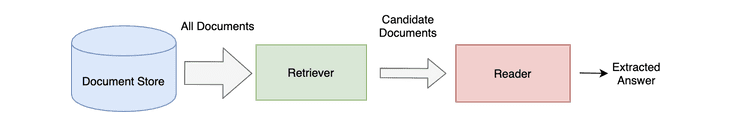

## Readers 

* Readers, also known as Open-Domain QA systems in Machine Learning speak, are powerful models that do close analysis of documents and perform the core task of question answering. 

* The Readers in Haystack are trained from the latest transformer based language models and can be significantly sped up using GPU acceleration. 

* However, it is not currently feasible to use the Reader directly on large collection of documents.

## Retriever

* The Retriever assists the Reader by acting as a lightweight filter that reduces the number of documents that the Reader has to process. 

It does this by:

  * Scanning through all documents in the database
  * Quickly identifying the relevant and dismissing the irrelevant
  * Passing on only a small candidate set of documents to the Reader

Current methods fall into one of the two categories:

* sparse

      - keyword based
      - fast indexing and querying
      - e.g. BM25
      
* dense

      - neural network based
      - computationally heavy indexing but fast querying
      - e.g. Dense Passage Retrieval
    


## Use cases
https://haystack.deepset.ai/docs/latest/use_casesmd